In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        nA = Q[observation].shape[0]
        max_action = np.argmax(Q[observation]) 
        return np.eye(nA)[max_action]

    return policy_fn

In [38]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    def run_episode(policy):
        observations, actions, rewards = [], [], []
        observation = env.reset()
        while True:
            action = np.random.choice(range(env.action_space.n),p=policy(observation))#np.argmax(policy(observation))
            next_observation, reward, done, _ = env.step(action)
            
            observations.append(observation)
            actions.append(action)
            rewards.append(reward)
            
            observation = next_observation
            
            if done:
                break
        
        return observations, actions, rewards
    
    def calculate_return(t, rewards):
        T = len(rewards) 
        return np.sum([discount_factor**(k-t)*rewards[k] for k in range(t,T)])

    def print_observation(observation):
        score, dealer_score, usable_ace = observation
        print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
              score, usable_ace, dealer_score))
    
    def print_transitions(observations, rewards, actions):
        for obs, r, action in zip(observations, rewards, actions):
            print()
            print_observation(obs)
            print("Action: {}".format(action))
            print("Reward: {}\n".format(r))
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of sum of weights for each state-action pair
    C = defaultdict(float)
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for eps in range(num_episodes):
        if eps % 1000 == 0:
            print("\rEpisode {}/{}.".format(eps, num_episodes), end="")
            sys.stdout.flush()
        
        # Run episode
        observations, actions, rewards = run_episode(behavior_policy)
        #print_transitions(observations, rewards, actions)
        
        G = 0   # The current return from t up to T
        W = 1   # The current importance weight from T down to t
    
        T = len(observations)
        for t in reversed(range(T)):
            #print("t: ",t)
            state, action = observations[t], actions[t]
            #print("state: {}, action: {}".format(state,action))
            G = discount_factor*G + rewards[t]#calculate_return(t, rewards)
            #print("G: ",G)
            C[(state,action)] += W
            Q[state][action] += (W/C[(state,action)])*(G - Q[state][action])
            #print("Q({},{}): {}".format(state,action,Q[state][action]))
            #print("target_action: ",np.argmax(target_policy(state)))
            if action != np.argmax(target_policy(state)):
                break
            W /= behavior_policy(state)[action]
            #print("W: ",W)
        
    return Q, target_policy

In [39]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 499000/500000.

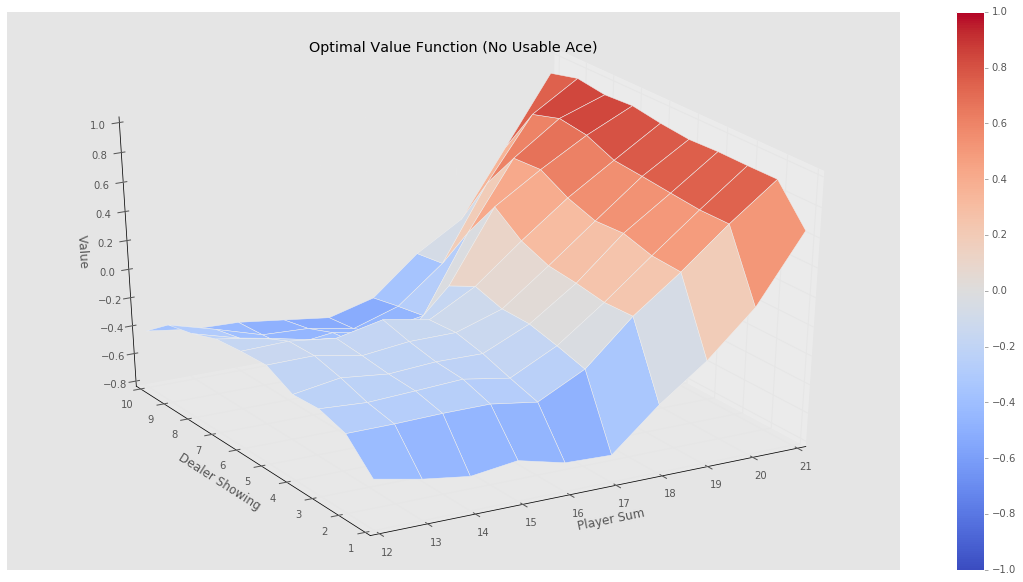

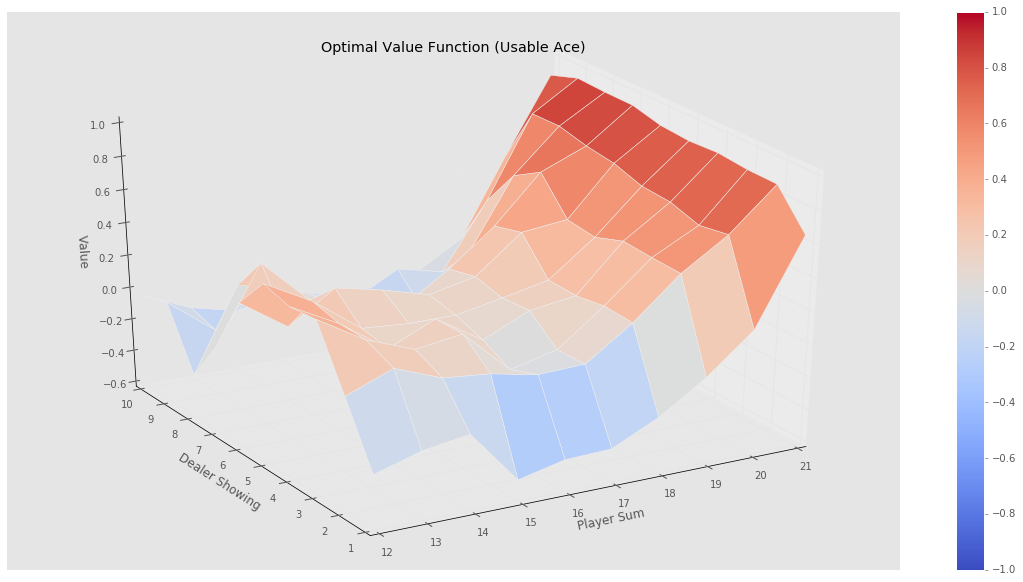

In [40]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")